In [5]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import json

In [82]:
# import file
tree = ET.parse('2.kml')
root = tree.getroot()

In [83]:
# create empty array 
arr = np.empty((0,2))

for i,placemark in enumerate(root.iter('{http://www.opengis.net/kml/2.2}Placemark')):
    # Extract relevant data from placemark
    name = placemark.find('{http://www.opengis.net/kml/2.2}name').text
    coordinates = placemark.find('{http://www.opengis.net/kml/2.2}Point/{http://www.opengis.net/kml/2.2}coordinates').text
    
    # Add x,y coordinates to arrays 
    # split at "," and again at space for x coordinate
    x = float(coordinates.split(',')[0].split(" ")[-1])
    y = float(coordinates.split(',')[1])
    arr = np.append(arr,[[x,y]],axis=0)

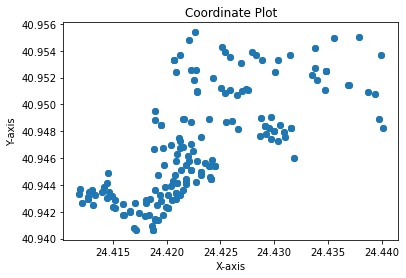

In [84]:
# Plot datapoints 
plt.scatter(arr[:,0],arr[:,1])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Coordinate Plot')

# Adding annotations for each point
#for i, txt in enumerate(arr[:,0]):
#    plt.annotate(i+1, (arr[i][0], arr[i][1]), textcoords='offset points', xytext=(0, 10), ha='center')

plt.show()

In [85]:
#instead of iterating over dims using loop,
#use Numpy's built in functions
def eucl_dist(x, y):
    x = np.array(x)
    y = np.array(y)
    distance = np.linalg.norm(x - y)
    return distance

def path_lenght(array):
    differences = np.diff(array, axis=0)  # Calculate the differences between consecutive points
    distances = np.linalg.norm(differences, axis=1)  # Calculate the Euclidean distances
    length = np.sum(distances)  # Sum up the distances
    length += np.linalg.norm(array[-1] - array[0])  # Add the distance between the last and first points
    return length


def distance_matrix2(points):
    points_size = points.shape[0]
    dist_mat = np.zeros((points_size, points_size))
    
    for i in range(points_size):
        for j in range(i+1, points_size):  # Iterate only over the upper triangular part
            dist = eucl_dist(points[i], points[j])
            dist_mat[i, j] = dist
            dist_mat[j, i] = dist  # Copy the value to the lower triangular part
    
    return dist_mat

# optimze code by using Numpy's broadcasting feature
# (allows element-wise operations without explicit loops)
def distance_matrix(points):
    # padd the points matrix 
    dist_mat = np.linalg.norm(points[:, np.newaxis] - points, axis=-1)
    return dist_mat

<AxesSubplot:>

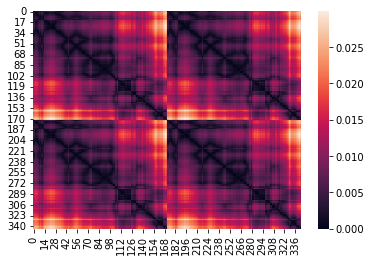

In [86]:
dist_map = distance_matrix(arr)
sns.heatmap(dist_map)

In [87]:
def inverse_distance_matrix(points):
    points_size = points.shape[0]
    
    # Calculate distance matrix using vectorized operations
    dist_mat = np.linalg.norm(points[:, np.newaxis] - points, axis=-1)
    
    # Create an identity matrix and calculate inverse distances using broadcasting
    #np.where(condition,x,y)
    # np.eye is tru at diag.
    # when cond is true, it assigns 0.0
    inv_dist_mat = np.where(np.eye(points_size, dtype=bool), 0.0, 1.0 / dist_mat)
    
    return inv_dist_mat


C:\Users\DIMITRIS\AppData\Local\Temp\ipykernel_3408\2777363980.py:11: RuntimeWarning: divide by zero encountered in divide
  inv_dist_mat = np.where(np.eye(points_size, dtype=bool), 0.0, 1.0 / dist_mat)


<AxesSubplot:>

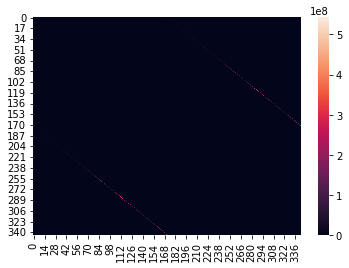

In [88]:
inv_dist_mat = inverse_distance_matrix(arr)
sns.heatmap(inv_dist_mat)

In [94]:
class Ant:
    def __init__(self, n_locations):
        self.n_locations = n_locations
        self.position = np.random.choice(n_locations)
        
        self.places_visited = [self.position]
        self.places_left = list(np.arange(n_locations))
        self.places_left.remove(self.position)
        
        self.phero_graph = np.full((n_locations,n_locations),0.0)
        self.tour_cost = 0.0

    def ant_trip(self, g_phero_graph, dist_mat, inv_dist_mat, alpha=1, beta=1, Q=1):
        #range based loop to avoid unessecary list indexing
        for _ in range(len(self.places_left)):
            # vectorized operations
            allowed_weights = (g_phero_graph[self.position, self.places_left] ** alpha) * (inv_dist_mat[self.position, self.places_left] ** beta)
            allowed_weights_sum = np.sum(allowed_weights)
            travel_probas = allowed_weights / allowed_weights_sum

            next_destination = np.random.choice(self.places_left, p=travel_probas)

            self.tour_cost += dist_mat[self.position, next_destination]

            self.position = next_destination
            self.places_visited.append(next_destination)
            self.places_left.remove(next_destination)

        for i, j in zip(self.places_visited[:-1], self.places_visited[1:]):
            self.phero_graph[i, j] = Q / self.tour_cost

    def ant_flush(self):
        
        self.position = np.random.choice(self.n_locations)
        self.places_visited = [self.position]
        self.places_left = list(np.arange(self.n_locations))
        self.places_left.remove(self.position)
        self.tour_cost = 0.0


In [95]:
def update_pheromones(g_phero_graph, ants, evapo_coef=0.05):
    evaporation_component = (1 - evapo_coef) * g_phero_graph
    deposition_component = np.sum([ant.phero_graph for ant in ants], axis=0)
    new_pheromones = evaporation_component + deposition_component
    new_pheromones = np.maximum(new_pheromones, 1e-08)
    return new_pheromones


In [116]:
#new
best_paths = []
def aco(points, alpha, beta, evapo_coef, colony_size, num_iter):
    
    n_locations = points.shape[0] # total number of points
    
    # Compute (once) the distance matrices
    dist_mat = distance_matrix(points)
    inv_dist_mat = inverse_distance_matrix(points)
    
    # Initialize ant colony
    ants = [Ant(n_locations) for _ in range(colony_size)]
    
    # Determine initial pheromone value
    phero_init = (inv_dist_mat.mean())**(beta/alpha)
    g_phero_graph = np.full((n_locations, n_locations), phero_init) # pheromone matrix (arbitrary initialization)
    
    # Determine scaling coefficient "Q"
    for ant in ants:
        ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, alpha, beta, Q=1)
    best_ant = min(ants, key=lambda ant: ant.tour_cost)
    Q = best_ant.tour_cost * phero_init / (0.1 * colony_size)
    print(Q)
    
        
    best_path_length = best_ant.tour_cost
    best_path = best_ant.places_visited.copy()
    
    monitor_costs = np.zeros(num_iter)
    
    for i in tqdm(range(num_iter)):
        for ant in ants:
            ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, alpha, beta, Q)
        
        g_phero_graph = update_pheromones(g_phero_graph, ants, evapo_coef)
        
        iteration_winner = min(ants, key=lambda ant: ant.tour_cost)
        best_path_iteration = iteration_winner.places_visited
        
        # Update global best if better
        if best_path_length > iteration_winner.tour_cost:
            best_ant = iteration_winner
            best_path = best_path_iteration.copy()
            best_path_length = iteration_winner.tour_cost
            
        monitor_costs[i] = best_path_length
        #save best path
        best_paths.append(best_path_length)

        
        for ant in ants:
            ant.ant_flush()
    
    return best_path, monitor_costs


C:\Users\DIMITRIS\AppData\Local\Temp\ipykernel_3408\2777363980.py:11: RuntimeWarning: divide by zero encountered in divide
  inv_dist_mat = np.where(np.eye(points_size, dtype=bool), 0.0, 1.0 / dist_mat)


0.8019053099894903


100%|██████████| 100/100 [00:11<00:00,  8.87it/s]


16.148083376867742



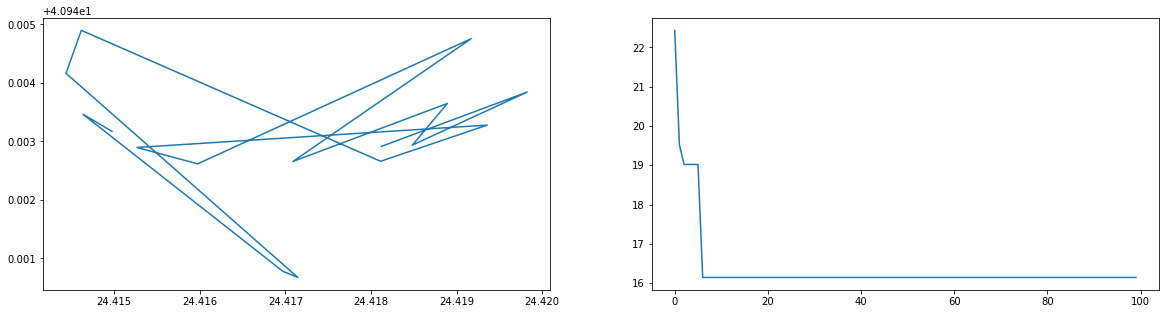

In [123]:
best_path, monitor_costs = aco(points = points, 
                               alpha = 0.8, 
                               beta = 1, 
                               evapo_coef = 0.1, 
                               colony_size = 100, 
                               num_iter = 100)


print (monitor_costs[-1])
print('')

plt.figure(figsize=(20,5));
plt.subplot(1,2,1);
plt.plot(arr[best_path,0],
         arr[best_path,1]);


plt.subplot(1,2,2);
plt.plot(np.arange(len(monitor_costs)),monitor_costs);

In [120]:
best_paths

[22.126807251389508,
 20.261449859729293,
 19.81085038423499,
 19.536705806261683,
 17.32418269123873,
 17.32418269123873,
 17.32418269123873,
 17.32418269123873,
 17.32418269123873,
 17.32418269123873,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 17.256950649699284,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,
 15.937999324845068,

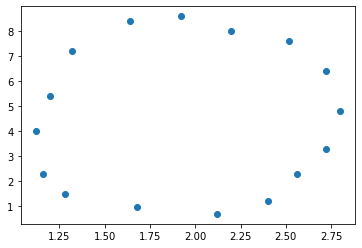

In [122]:
points = np.array([[2.12,0.7],[1.68,0.97],[1.28,1.5],[1.16,2.3],[1.12,4],
                  [1.2,5.4],[1.32,7.2],[1.64,8.4],[1.92,8.6],[2.2,8],
                  [2.52,7.6],[2.72,6.4],[2.8,4.8],[2.72,3.3],[2.56,2.3],[2.4,1.2]])
#points.shape
plt.scatter(points[:,0],points[:,1]);

In [31]:
#save results


monitor_costs = [int(cost) for cost in monitor_costs]
best_path = [int(point) for point in best_path]

# Save variables to a file
data = {'monitor_costs': monitor_costs, 'best_path': best_path}
with open('save_file.json', 'w') as file:
    json.dump(data, file)